Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
# %load_ext watermark
# %watermark -a 'Sebastian Raschka' -v -p torch

- Runs on CPU (not recommended here) or GPU (if available)

# Model Zoo -- CNN Smile Classifier (VGG16 Architecture, CelebA)

Implementation of the VGG-16 [1] architecture on the CelebA face dataset [2] to train a smile classifier.  


References
    
- [1] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.
- [2] Zhang, K., Tan, L., Li, Z., & Qiao, Y. (2016). Gender and smile classification using deep convolutional neural networks. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops (pp. 34-38).


The following table (taken from Simonyan & Zisserman referenced above) summarizes the VGG19 architecture:

![](../images/vgg16/vgg16-arch-table.png)

**Note that the CelebA images are 218 x 178, not 256 x 256. We resize to 128x128**

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings
- Note that for small datatsets, it is not necessary and better not to use multiple workers as it can sometimes cause issues with too many open files in PyTorch. So, if you have problems with the data loader later, try setting `NUM_WORKERS = 0` instead.

In [2]:
BATCH_SIZE = 256
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
NUM_WORKERS = 4

## Imports

In [3]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

from datetime import datetime


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Dataset

Note that the approx. 200,000 CelebA face image dataset is relatively large (approx. 1.3 Gb). If the following automatic download below does not work (e.g., returning a `BadZipFile: File is not a zip file` error), this is usually to rate limit restrictions by the provider hosting the dataset. You can try to download the dataset manually via the download link provided by the author on the official CelebA website at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. 

Alternatively, you can download the dataset from here: https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?. 
1. Delete the existing `celeba` folder with the partially downloaded files.
2. Place the .zip file in the same directory as this notebook, then unzip it.
3. The new `celeba` folder should contain the following files:

![](./images/celeba-files.png)

4. Unzip the `celeba/img_align.celeba.zip` archive inside the `celeba` folder
5. Call the `get_dataloaders_celeba` below with `download=False`


In [4]:
from pathlib import Path
path_data = Path.cwd().parent.parent.parent / 'DATA'
print(path_data)

/gpfsdswork/projects/rech/dcf/ulb98yg/DATA


In [5]:
##########################
### Dataset
##########################


custom_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def get_dataloaders_celeba(batch_size, num_workers=0,
                           train_transforms=None,
                           test_transforms=None,
                           download=True):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()
        
    get_smile = lambda attr: attr[31]

    train_dataset = datasets.CelebA(root=path_data,
                                    split='train',
                                    transform=train_transforms,
                                    target_type='attr',
                                    target_transform=get_smile,
                                    download=download)

    valid_dataset = datasets.CelebA(root=path_data,
                                    split='valid',
                                    target_type='attr',
                                    target_transform=get_smile,
                                    transform=test_transforms)

    test_dataset = datasets.CelebA(root=path_data,
                                   split='test',
                                   target_type='attr',
                                   target_transform=get_smile,
                                   transform=test_transforms)


    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)

    valid_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)
    
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    return train_loader, valid_loader, test_loader


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    download=False,
    num_workers=4)

Note that the target vectors of the CelebA datasets are vectors containing 40 attributes: 
    
```
    00 - 5_o_Clock_Shadow
    01 - Arched_Eyebrows
    02 - Attractive 
    03 - Bags_Under_Eyes
    04 - Bald
    05 - Bangs
    06 - Big_Lips
    07 - Big_Nose
    08 - Black_Hair
    09 - Blond_Hair
    10 - Blurry 
    11 - Brown_Hair 
    12 - Bushy_Eyebrows 
    13 - Chubby 
    14 - Double_Chin 
    15 - Eyeglasses 
    16 - Goatee 
    17 - Gray_Hair 
    18 - Heavy_Makeup 
    19 - High_Cheekbones 
    20 - Male 
    21 - Mouth_Slightly_Open 
    22 - Mustache 
    23 - Narrow_Eyes 
    24 - No_Beard 
    25 - Oval_Face 
    26 - Pale_Skin 
    27 - Pointy_Nose 
    28 - Receding_Hairline 
    29 - Rosy_Cheeks 
    30 - Sideburns 
    31 - Smiling 
    32 - Straight_Hair 
    33 - Wavy_Hair 
    34 - Wearing_Earrings 
    35 - Wearing_Hat 
    36 - Wearing_Lipstick 
    37 - Wearing_Necklace 
    38 - Wearing_Necktie 
    39 - Young      
```

Via the custom `get_smile` function above [31], we fetched the Smiling label.

## Model

In [6]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 3

# Architecture
num_features = 128*128
num_classes = 2

In [7]:
##########################
### MODEL
##########################

from models import VGG16
    
torch.manual_seed(random_seed)
model = VGG16(num_features=num_features,
              num_classes=num_classes)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

## Training

In [8]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% | Valid: %.3f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_accuracy(model, valid_loader)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/003 | Batch 0000/0636 | Cost: 5911.8281
Epoch: 001/003 | Batch 0050/0636 | Cost: 0.6789
Epoch: 001/003 | Batch 0100/0636 | Cost: 0.6069
Epoch: 001/003 | Batch 0150/0636 | Cost: 0.5325
Epoch: 001/003 | Batch 0200/0636 | Cost: 0.4368
Epoch: 001/003 | Batch 0250/0636 | Cost: 0.3337
Epoch: 001/003 | Batch 0300/0636 | Cost: 0.3150
Epoch: 001/003 | Batch 0350/0636 | Cost: 0.2149
Epoch: 001/003 | Batch 0400/0636 | Cost: 0.3093
Epoch: 001/003 | Batch 0450/0636 | Cost: 0.2983
Epoch: 001/003 | Batch 0500/0636 | Cost: 0.2184
Epoch: 001/003 | Batch 0550/0636 | Cost: 0.2569
Epoch: 001/003 | Batch 0600/0636 | Cost: 0.2941
Epoch: 001/003 | Train: 88.344% | Valid: 88.253%
Time elapsed: 12.32 min
Epoch: 002/003 | Batch 0000/0636 | Cost: 0.2687
Epoch: 002/003 | Batch 0050/0636 | Cost: 0.2819
Epoch: 002/003 | Batch 0100/0636 | Cost: 0.2386
Epoch: 002/003 | Batch 0150/0636 | Cost: 0.2230
Epoch: 002/003 | Batch 0200/0636 | Cost: 0.2552
Epoch: 002/003 | Batch 0250/0636 | Cost: 0.1942
Epoch: 002/0

In [9]:
model

VGG16(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Save

In [10]:
path_results = Path.cwd().parent.parent / 'results'
save_path = str(path_results / 'classifiers' /  f'VGG16_celeba_{datetime.now().strftime("%Y%m%d_%H%M")}.pth')
torch.save(model.state_dict(), save_path)

## Evaluation

In [11]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 90.24%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


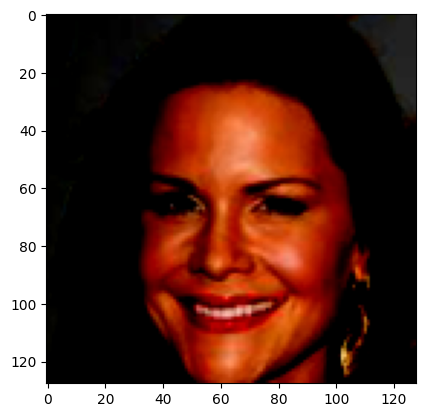

In [12]:
# from helper_data import UnNormalize

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
# unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    
plt.imshow(np.transpose((features[3]), (1, 2, 0)))

In [13]:
model.eval()
logits, probas = model(features.to(device)[3, None])
print('Probability Smile %.2f%%' % (probas[0][1]*100))

Probability Smile 99.99%
